In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [137]:
df = pd.read_pickle("./filtered_data.pkl")
df.shape

(19816, 15)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19816 entries, 0 to 19815
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome_name              19816 non-null  object 
 1   under_pressure            4272 non-null   float64
 2   sub_type_name             19816 non-null  object 
 3   body_part_name            19816 non-null  object 
 4   shot_first_time           5886 non-null   object 
 5   x                         19816 non-null  float64
 6   y                         19816 non-null  float64
 7   pass_deflected            0 non-null      object 
 8   shot_one_on_one           928 non-null    object 
 9   play_pattern_name         19816 non-null  object 
 10  type_name                 19816 non-null  object 
 11  goalkeeper_position_name  0 non-null      object 
 12  technique_name            19816 non-null  object 
 13  distance_to_goal          19816 non-null  float64
 14  angle_

In [139]:
df

,outcome_name,under_pressure,sub_type_name,body_part_name,shot_first_time,x,y,pass_deflected,shot_one_on_one,play_pattern_name,type_name,goalkeeper_position_name,technique_name,distance_to_goal,angle_to_goal
0,Blocked,NaN,Open Play,Right Foot,NaN,107.1,26.6,NaN,NaN,Regular Play,Shot,NaN,Normal,18.600269,15.850859
1,Blocked,NaN,Open Play,Right Foot,NaN,113.7,54.0,NaN,NaN,Regular Play,Shot,NaN,Normal,15.352199,11.720028
2,Off T,1.0,Open Play,Left Foot,True,115.7,50.5,NaN,NaN,Regular Play,Shot,NaN,Overhead Kick,11.346365,15.263642
3,Off T,NaN,Open Play,Head,NaN,113.9,38.6,NaN,NaN,From Throw In,Shot,NaN,Normal,6.258594,299.994760
4,Wayward,NaN,Open Play,Right Foot,NaN,96.7,47.2,NaN,NaN,From Free Kick,Shot,NaN,Half Volley,24.387087,16.351007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19811,Saved,NaN,Open Play,Right Foot,NaN,109.1,29.8,NaN,NaN,Regular Play,Shot,NaN,Normal,14.928161,20.853466
19812,Saved,NaN,Open Play,Right Foot,NaN,114.6,51.4,NaN,True,From Counter,Shot,NaN,Normal,12.614278,15.176401
19813,Blocked,NaN,Open Play,Right Foot,NaN,98.3,56.9,NaN,NaN,From Throw In,Shot,NaN,Normal,27.504545,12.065808
19814,Saved,NaN,Open Play,Left Foot,NaN,102.9,58.1,NaN,NaN,Regular Play,Shot,NaN,Normal,24.900201,11.658888


In [140]:
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer import Sbopen

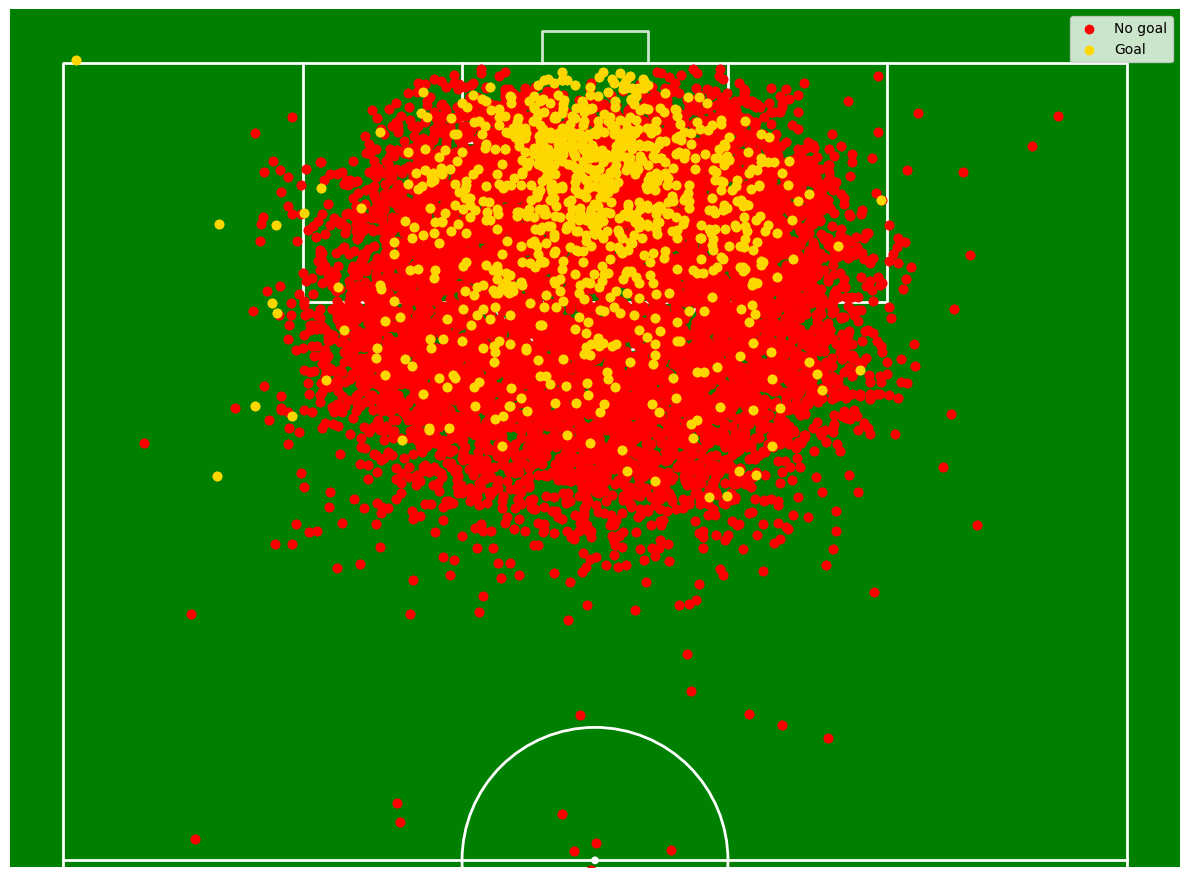

In [141]:


# filter goals / non-shot goals
df_goals = df[df.outcome_name == 'Goal'].copy()
df_non_goal_shots = df[df.outcome_name != 'Goal'].copy()

# setup the pitch
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='green', line_color='white')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                    c='red',
                    marker='o',
                    ax=ax, label="No goal")

sc2 = pitch.scatter(df_goals.x, df_goals.y,
                    c='gold',
                    marker='o',
                    ax=ax, label="Goal")

plt.legend(loc='best')
plt.show()

In [171]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [173]:
df = df.copy()


In [175]:
features = [
    'under_pressure',
    'sub_type_name',
    'body_part_name',
    'shot_first_time',
    'x',
    'y',
    'shot_one_on_one',
    'play_pattern_name',
    'type_name',
    'technique_name',
    'distance_to_goal',
    'angle_to_goal'
]
target = "outcome"

df = df[features + [target]]


In [177]:
# Replace booleans with strings
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(str)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)


for col in df.select_dtypes(include=['float', 'int']).columns:
    df[col] = df[col].fillna(df[col].median())


for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].replace("nan", "Unknown")

In [179]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [180]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

In [181]:
model = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=200))
])

In [182]:
model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sub_type_name', 'body_part_name', 'shot_first_time', 'shot_one_on_one',
       'play_pattern_name', 'type_name', 'technique_name'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['under_pressure', 'x', 'y', 'distance_to_goal', 'angle_to_goal'], dtype='object'))])),
                ('clf', LogisticRegression(max_iter=200))])

In [183]:
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 0.90815039111784
Test Accuracy: 0.9081735620585267


In [192]:
probabilities = model.predict_proba(X_test)[:, 1]


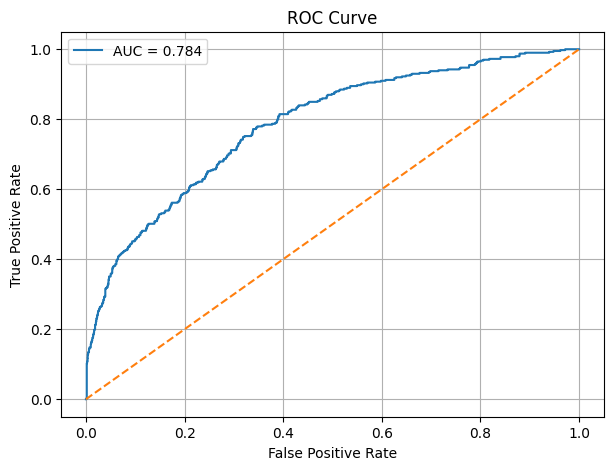

In [190]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
